In [1]:
from os.path import exists
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from pyckmeans import CKmeans
from pyckmeans import MultiCKMeans
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 pynndescent==0.5.7


In [17]:
# at the file there are mixed tabs with single spaces
# convert all of them to single spaces
def remove_extra_spaces(file):
    
    fin = open(file, "rt")
    fout = open("dataSp.txt", "wt")

    for line in fin:
        for i in line:
            
            if i == " " or i == "\t" or i == "":
                fout.write(' ')
            else:
                fout.write(i)

    fin.close()
    fout.close()
    print("------End of white space convertion------\n")
    return 'dataSp.txt'

def plot_heatmap_original(file="dataSp.txt"):
    
    df = pd.read_csv(file,' ', comment='#')
    df = df.set_index(df.columns[0])
#     df = df.drop('tumor')
#     df = df.drop('malignant(1=no,2=yes,0=unresolved)')
#     df = df.drop('non-malignantcelltype(1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)')
    df
    p1 = sns.heatmap(df, vmin = 0, vmax = 1)

def plot_heatmap_transformed(file="temp4.txt"):
    
    df = pd.read_csv(file,' ', comment='#')
    df = df.set_index(df.columns[0])
    #df = df.drop('non-malignantcelltype(1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)')
    df
    p1 = sns.heatmap(df, vmin = 0, vmax = 1)

def plot_high_exp_genes(file):
    adata = sc.read(file, var_names='gene_symbols', cache=True)   
    adata.var_names_make_unique() 
    sc.pl.highest_expr_genes(adata, n_top=15, )
#     sc.pp.normalize_total(adata, target_sum=1e4)
#     sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#     sc.pl.highly_variable_genes(adata)

def plot_violin_tcounts(file):
    adata = sc.read(file, var_names='gene_symbols', cache=True)   
    adata.var_names_make_unique() 
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

def plot_most_var_genes(file):
    adata = sc.read(file, var_names='gene_symbols', cache=True)   
    adata.var_names_make_unique() 
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    
# def plot_heatmap(file):
#     adata = sc.read(file, var_names='gene_symbols', cache=True)   
#     adata.var_names_make_unique()
#     markers = ['C9orf152', 'RPS11', 'ELMO2', 'CREB3L1', 'PNMA1', 'TMEM216']
#     sc.pl.heatmap(adata,markers, groupby='Cy72_CD45_H02_S758_comb,Cy72_CD45_D12_S720_comb', swap_axes=True)
    
# create a new txt file containing only the most variable genes 
# remove genes that are either expressed in less than r% of cells (rare genes) or expressed in at least (100-r)% of cells (ubiquitous genes)
# also remove the info about tumors
def filter_rare_ubiquitous_genes(r, file):
    
    
    lines = []
    
    with open(file) as f:
        lines = f.readlines()
    
    fout = open("significant.txt", "wt")
    cells = len(lines[0].split()) - 1
    fout.write(lines[0])
    genes = 0
    
    for line in lines[4:]:
        genes += 1 
    
    #print(genes)  
    genes_kept = 0
    fout.write(lines[3])
    
    for line in lines[4:]:
    #print(line)
        expressed_in_cells = 0
        values=line.split(' ')
    #print(values)
        for expression in values[1:]:
            if float(expression)!=0:
                expressed_in_cells+=1
        #print(expressed_in_cells)
        if values[0] == "RPS24":
            print(expressed_in_cells)
        if expressed_in_cells > r*cells/100 and expressed_in_cells < (100-r)*cells/100:
            #print("gene: ")
            #print(expressed_in_cells)
            fout.write(line)
            genes_kept+=1
            
    #return fout
    print("------End of initial filtering------")
    print(str((genes_kept/genes)*100)+" % genes passed the initial filtering\n")   
    fout.close()
    
    return "significant.txt"

# initially we have a matrix with cells as coloumns and genes as rows
# we need the inverted matrix: coloumns-genes and rows-cells
# invert the single cell txt file
def invert_single_cell_matrix (file):
    
    genes = 0
    with open(file) as f:
        lines = f.readlines()
        
    for line in lines:
        genes += 1 
        values=line.split(' ')
    
    # create a nested list
    # contains #genes sublists with #cell elements each
    # split the file in its lines and each line in its components - either name or count
    line_list = [[]] * genes

    index = 0
    for line in lines: 
        
        line_list[index] = []
        genes_exp=line.split(" ")
        
        for gene_exp in genes_exp:
            line_list[index].append(gene_exp)
            
        index+=1
    
    fout = "temp1.txt"
    fout = open("temp1.txt", "wt")
    
    for index in range(len(genes_exp)-1):
        #if i!=4645:
        for element in line_list:
            if len(element)>0:
                fout.write(element[index])
                fout.write(" ")
        fout.write('\n')
        
    with open("temp1.txt") as f:
        lines = f.readlines()
    

    #file = open("kat.txt")
    #lines = file.readlines()
    lines = lines[:-1]

    fout = open("temp2.txt", "wt")
    for l in lines:
        fout.write(l)
    #print(listt[126][4644])
    print("------End of inverting single cell matrix file------\n")
    return "temp2.txt"

# use highly_variable_genes of scanpy package to identify the most variable genes
def most_variable_genes (file):
    #adata = sc.read(file)
    #chunks = pd.read_table(file, index_col=0, chunksize=1000000)
    #df = pd.concat(chunks)
    #adata = sc.read(df)
    #print(adata)
    # the following line should be used on non-normalized data
    #sl=sc.pp.log1p(adata,copy=True)
    #df=sc.pp.highly_variable_genes(adata, inplace=False)
    adata = sc.read(file, var_names='gene_symbols', cache=True)   
    adata.var_names_make_unique() 
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    df=sc.pp.highly_variable_genes(adata, inplace=False)
#     print(adata)
#     adata.raw = adata
#     adata = adata[:, adata.var.highly_variable]
#     print(adata)
#     sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
#     sc.pp.scale(adata, max_value=10)
#     print(adata)
    #sc.pl.highly_variable_genes(adata)
    k=df.loc[df['highly_variable'] == True, ['dispersions']]
    
    #print("Most variable genes: ",len(k))
    
    #print(df)
    arr = df.to_numpy()
    r = 0
    with open(file) as f:
        lines = f.readlines()
        
    for line in lines:
        r += 1 
        c=line.split(' ')

    
# create a nested list
# contains #genes sublists with #cell elements each
# split the file in its lines and each line in its components - either name or count
    line_list = [[]] * r

    index = 0
    for line in lines:     
        line_list[index] = []
        genes_exp=line.split(" ")
        
        for gene_exp in genes_exp:
            line_list[index].append(gene_exp)
            
        index+=1
    print("Genes: ",len(line_list[0]))    
    fout = "temp3.txt"
    fout = open("temp3.txt", "wt")
    print(len(genes_exp))  
    for element in line_list:

        for index in range(len(genes_exp)-4):

            if len(element)>0 and (index == 0 or index == 1):
                fout.write(element[index])
                fout.write(" ")
            elif len(element)>0 and arr[index-1,4]== True and index >1:
                fout.write(element[index])
                fout.write(" ")
        fout.write('\n')
 
    with open("temp3.txt") as f:
        lines = f.readlines()

    lines = lines[:-1]

    fout = open("temp4.txt", "wt")
    for l in lines:
        fout.write(l)


    
    print("------End of most variable genes filtering------\n")
    return "temp4.txt"
    
def PCA_pipeline(data, variance_th = 0.9):
    
    #name = "pca_var"+str(i)+".jpg"
    pca = PCA()
    pca_data = pd.DataFrame(pca.fit_transform(data))
    pca_data.head()

    s=np.zeros(5000)
    pca_components=0
    for k in range(len(pca.explained_variance_ratio_)):
        if k==0:
            s[0]=pca.explained_variance_ratio_[0]
        else:
            s[k]=s[k-1]+pca.explained_variance_ratio_[k]
            if s[k]>variance_th and pca_components==0:
                pca_components=k
                
    figure(figsize=(8, 6), dpi=60)            
    plt.plot(s, marker='o', c='b')
    plt.xlabel('Number of dimensions')
    plt.ylabel('PCA explained variance');
    #plt.savefig(name)
    plt.show()
    
    print("PCA needs "+str(pca_components)+" components to reach "+str(variance_th*100)+  "% of the total variance")
    pca=PCA(n_components=pca_components)
    pca.fit(data)
    pca_data = pd.DataFrame(pca.transform(data))
    
    #name = "pca"+str(i)+".jpg"
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(pca_data[0], pca_data[1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('PCA');
    #plt.savefig(name)
    plt.show()
    
    return pca_components, pca_data

def TSNE_pipeline(data, components = 2):
    
    #name = "tsne"+str(i)+".jpg"
    tsne = TSNE(perplexity=30, n_iter=1000, verbose=1)
    tsne_data = tsne.fit_transform(data)
    
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('TSNE');
    #plt.savefig(name)
    plt.show()
    return tsne_data

def UMAP_pipeline(data,components=50):
    
    #name = "umap"+str(i)+".jpg"
    number_samples = data.shape[0]
    umap_components = min(components,number_samples//8)
    number_neighbors = 13
    umap_o = umap.UMAP()
    umap_data = umap_o.fit_transform(data)
    
    figure(figsize=(8, 6), dpi=60)
    plt.scatter(umap_data[:, 0], umap_data[:, 1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('UMAP');
    #plt.savefig(name)
    plt.show()
    return umap_data
    

def dim_reduction(file, method):
    
    with open(file) as f:
        lines = f.readlines()
        
    for line in lines:
        c=line.split(' ')

    data = pd.read_csv(file, sep=" ", usecols=range(2,len(c)-1))
    
    if method == 'TSNE':

        #print(data)
        scalar = StandardScaler()
        #remove the first column
        data_scaled = pd.DataFrame(scalar.fit_transform(data.loc[:, data.columns != "Unnamed: 4704"]), columns=data.loc[:, data.columns != "Unnamed: 0"].columns)
        data_scaled.head()
        #pca_components, pca_data = PCA_pipeline(data_scaled)
        #umap_components = UMAP_pipeline(data)
        tsne_data = TSNE_pipeline(data)
        return tsne_data
    
    if method == 'PCA':
        
        pca_components, pca_data = PCA_pipeline(data)
        return pca_data
        
    if method == 'PCA-TSNE':
        
        pca_components, pca_data = PCA_pipeline(data)
        tsne_data = TSNE_pipeline(pca_data)
        return tsne_data
    
    if method == 'UMAP':
        umap_data = UMAP_pipeline(data)
        return umap_data
    
    print("------End of dimentionality reduction------\n")

def true_data_labels(file):
    
    p = [x.split(' ')[1] for x in open(file).readlines()]
    li = []
    i=0
    for k in p:
        if i >0:
            li.append(int(k))
        i+=1  
    #print(li)
    true_labels = np.array(li)
    print(true_labels)
    return true_labels
    
#partition the data and for each partition try different number of clusters 
#for each partition and for each number of cluster create a binary matrix with the clustering labels
# each row contains at most one 1 (-one if the specific line was selected on the partition -none if it was not selected)
def binary_matrices (data, file, true_labels):
    
    Bs = {}
    for partition in range(1,5):
        #each partition takes 50% of the data
        x_tr,x_te,label_tr,label_te = train_test_split(data, true_labels, train_size = 0.5)
        print(x_tr, label_tr)
        print("------ Partition: "+str(partition)+" ------")
        for cluster in range(2,10):
            Bs.update({f'B_{partition}_{cluster}' : np.zeros((4642,cluster))})
            print("------ Number of clusters: "+str(cluster)+" ------")
            kmeans = KMeans(n_clusters=cluster, random_state=0).fit(x_tr)

            for value in range(0,len(Bs[f'B_{partition}_{cluster}'])):
                index = 0
                for part_data in x_tr:
                    #print(index)
                    if data[value][0] == part_data[0] and data[value][1] == part_data[1]:
                        #print(kmeans.labels_[index])
                        Bs[f'B_{partition}_{cluster}'][value][kmeans.labels_[index]]=1
                        #print("break")
                        break
                    else :
                        index+=1
            #print(Bs[f'B_{partition}_{cluster}'])
    return Bs

def consensus_clustering_nclusters(data, true_labels):
    mckm = MultiCKMeans(k=[2, 3, 4, 5, 6, 7, 8], n_rep=100, p_samp=0.8, p_feat=0.5)
    mckm.fit(data)
    mckm_res = mckm.predict(data, return_cls=True)

    # clustering metrics
    print('Metrics:')
    print(mckm_res.metrics)

    # plot clustering metrics against k
    # BIC, DB: lower is better
    # SIL, CH: higher is better
    mckm_res.plot_metrics(figsize=(10,5))
    plt.show()
    

def consensus_clustering_one_cluster(data, true_labels, clu):
    
    ARI = []
    
    for cluster in range(2,9):
        #cluster according to BIC criterion
        ckm = CKmeans(k=cluster, n_rep=100, p_samp=0.8, p_feat=0.5)
        ckm.fit(data)
        ckm_res = ckm.predict(data)

        # consensus matrix
        ckm_res.cmatrix

        # clustering metrics
#         print('Bayesian Information Criterion:', ckm_res.bic)
#         print('Davies-Bouldin Index:', ckm_res.db)
#         print('Silhouette Score:', ckm_res.sil)
#         print('Calinski-Harabasz Index:', ckm_res.ch)

        # consensus clusters
        #print('Cluster Membership:', ckm_res.cl)
    
        #compute ARI 
        ARI.append(adjusted_rand_score (true_labels, ckm_res.cl))
        #print("ARI: ", ARI)
        
    ckm = CKmeans(k=clu, n_rep=100, p_samp=0.8, p_feat=0.5)
    ckm.fit(data)
    ckm_res = ckm.predict(data)
    print(ckm_res.cl)
    print("ARI for ", clu, " clusters: ", ARI[clu-2])
    print(ARI)
    clusters = [2,3,4,5,6,7,8]
    plt.scatter(x=clusters, y=ARI)
    plt.plot(clusters,ARI)
    plt.xlabel("Number of clusters")
    plt.ylabel("ARI")
    #plt.savefig(name)
    plt.show()
    
    plt.scatter(x=data[:,0], y=data[:,1], c=true_labels)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('True labels');
    #plt.savefig(name)
    plt.show()
    #figure(figsize=(8, 6), dpi=60)
    plt.scatter(x=data[:,0], y=data[:,1], c=(ckm_res.cl))
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('Infered labels');
    plt.show()
    
def kmeans(data, true_labels):
 
    ARI = []
    CH = []
    #for cluster in range(2,10):
    for cluster in range(2,9):
        kmeans = KMeans(n_clusters=cluster, random_state=0).fit(data)
        print(kmeans.labels_)
        CH.append(metrics.calinski_harabasz_score(data, kmeans.labels_))
        #plt.scatter(x=data[:,0], y=data[:,1], c=kmeans.labels_)
        #plt.show()
        ARI.append(adjusted_rand_score (true_labels, kmeans.labels_))
    print("ARI: ", ARI[5])
    
    clusters = [2,3,4,5,6,7,8]
    plt.scatter(x=clusters, y=ARI)
    plt.plot(clusters,ARI)
    plt.xlabel("Number of clusters")
    plt.ylabel("ARI")
    #plt.savefig(name)
    plt.show()
    
    clusters = [2,3,4,5,6,7,8]
    plt.scatter(x=clusters, y=CH)
    plt.plot(clusters,CH)
    plt.xlabel("Number of clusters")
    plt.ylabel("CH")
    #plt.savefig(name)
    plt.show()
    
    kmeans = KMeans(n_clusters=6, random_state=0).fit(data)
    
    plt.scatter(x=data[:,0], y=data[:,1], c=true_labels)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('True labels');
    #plt.savefig(name)
    plt.show()
    #figure(figsize=(8, 6), dpi=60)
    plt.scatter(x=data[:,0], y=data[:,1], c=(kmeans.labels_))
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title('Infered labels');
    plt.show()
    
def filtering_step():
    
#     r = input("Enter your value r for filering: ")
#     #print(r)
#     file = input("Enter your input single cell data file: ")
 
#     if int(r) < 2 or int(r) > 10:
#         print("The r value for filtering is not acceptable. It is replaced with 6.")
#         r = 6
        
#     if exists(file) == False:
#         print("The single cell data file does not exist. It is replaced with the default file.")
#         file = "data2_clusters.txt"
    r=6
    file = "data2_clusters.txt"
    file = remove_extra_spaces(file) 
    #file = filter_rare_ubiquitous_genes(int(r), file)
    file = invert_single_cell_matrix(file)
    plot_high_exp_genes(file)
    plot_violin_tcounts(file)
    plot_most_var_genes(file)
    file = most_variable_genes(file)
    plot_high_exp_genes(file)
    return file


def dim_reduction_step(file): 
    
    data_tsne = dim_reduction(file, 'TSNE')
    data_umap = dim_reduction(file, 'UMAP')
    data_tsne_pca = dim_reduction(file, 'PCA-TSNE')
    #Bs = binary_matrices(data, file, true_labels)
    #print(Bs)
    return file, data_tsne, data_umap, data_tsne_pca
    
def consensus_step(file, data_tsne, data_umap, data_tsne_pca):
    true_labels = true_data_labels(file)
    consensus_clustering_nclusters(data_tsne, true_labels)
    consensus_clustering_one_cluster(data_tsne, true_labels, 6)
    consensus_clustering_nclusters(data_umap, true_labels)
    consensus_clustering_one_cluster(data_umap, true_labels, 6)
    consensus_clustering_nclusters(data_tsne_pca, true_labels)
    consensus_clustering_one_cluster(data_tsne_pca, true_labels, 6)

------End of white space convertion------

------End of inverting single cell matrix file------

... writing an h5ad cache file to speedup reading next time


/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell
    finished (0:00:00)


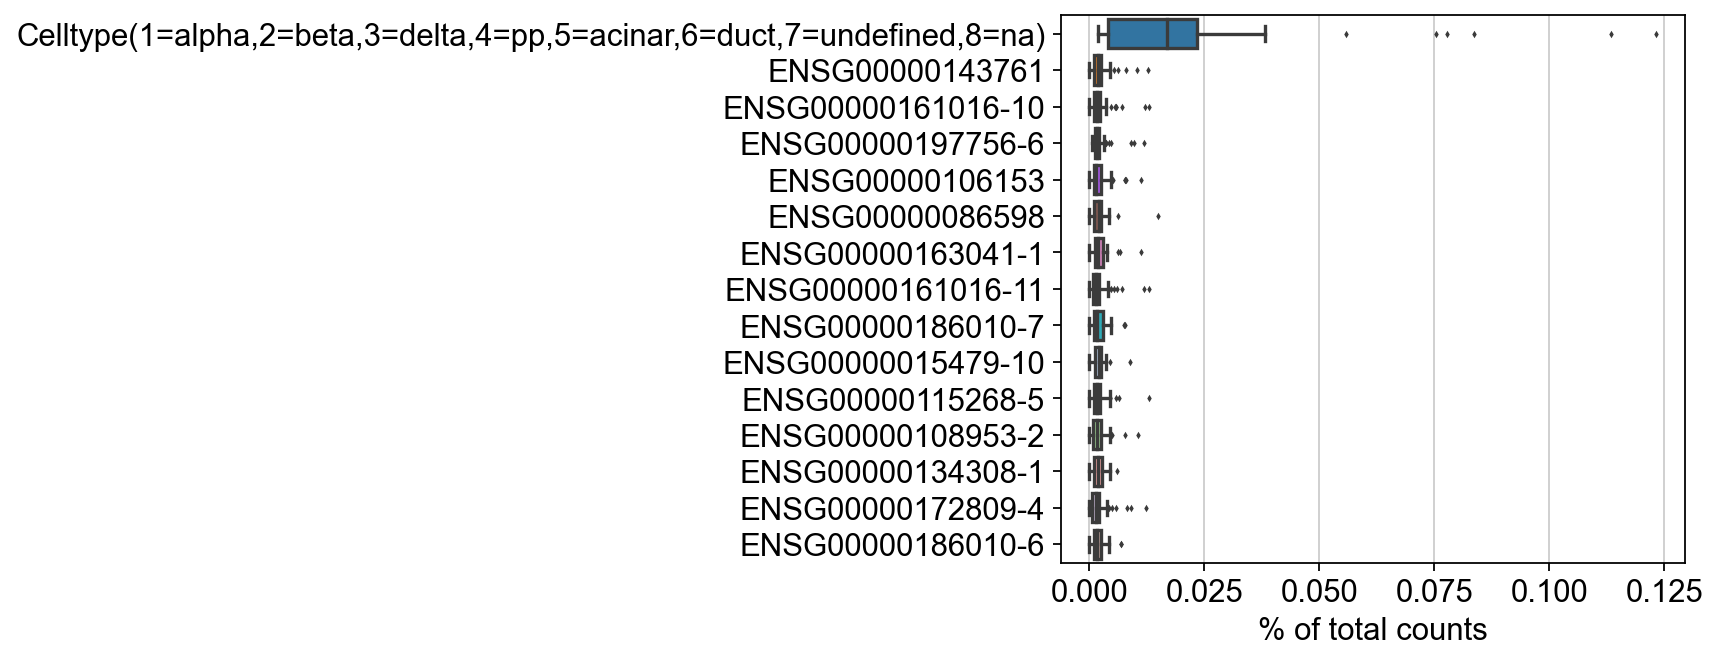

... reading from cache file cache/temp2.h5ad


/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


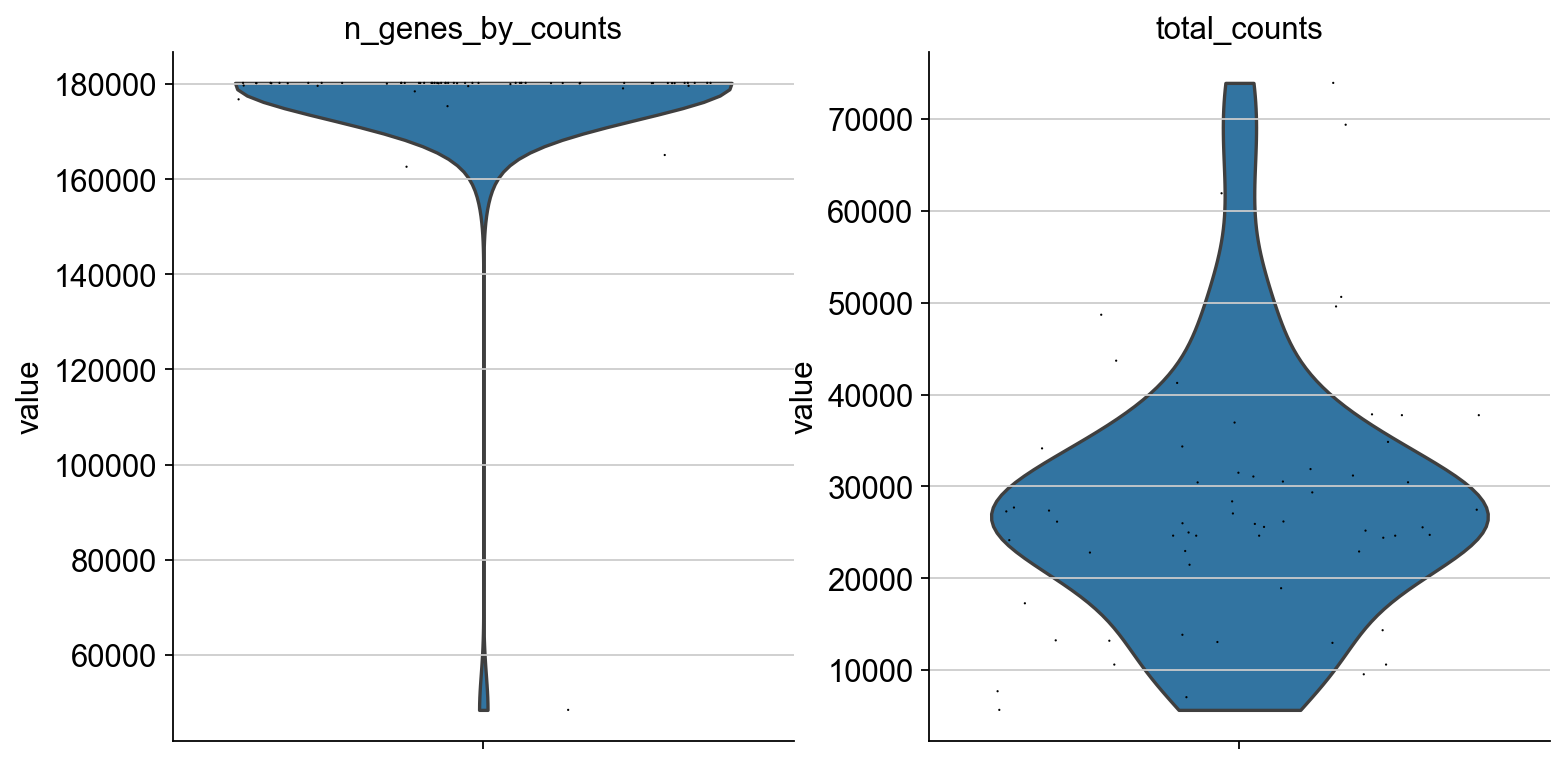

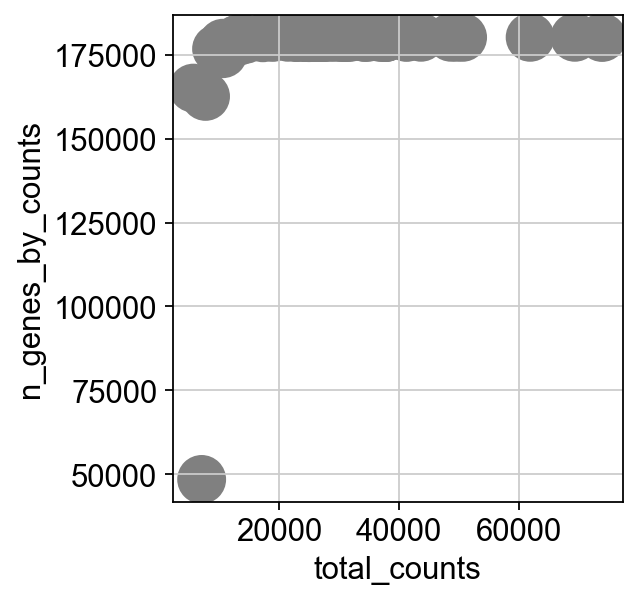

... reading from cache file cache/temp2.h5ad
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


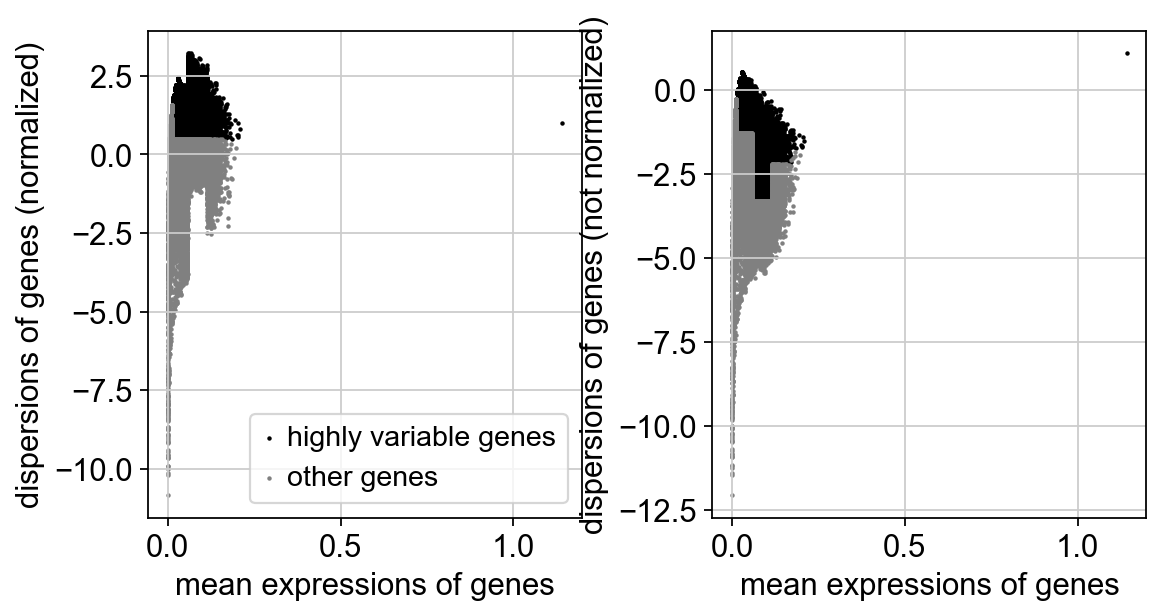

... reading from cache file cache/temp2.h5ad
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:02)
Genes:  180256
180256
------End of most variable genes filtering------

... writing an h5ad cache file to speedup reading next time
normalizing counts per cell
    finished (0:00:00)


/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


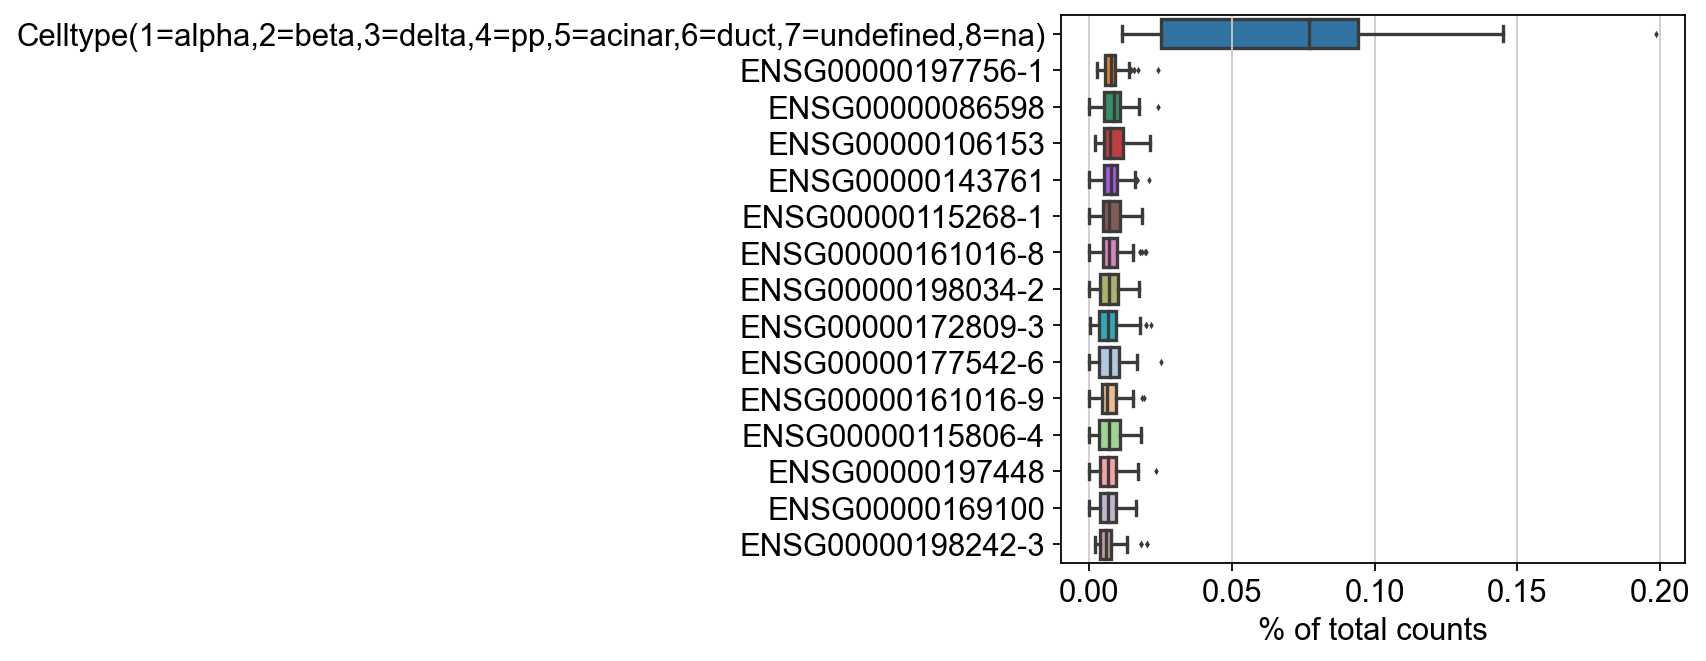

/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 60 nearest neighbors...
[t-SNE] Indexed 61 samples in 0.001s...
[t-SNE] Computed neighbors for 61 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 61 / 61
[t-SNE] Mean sigma: 17.651328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.748672
[t-SNE] KL divergence after 1000 iterations: 0.553749


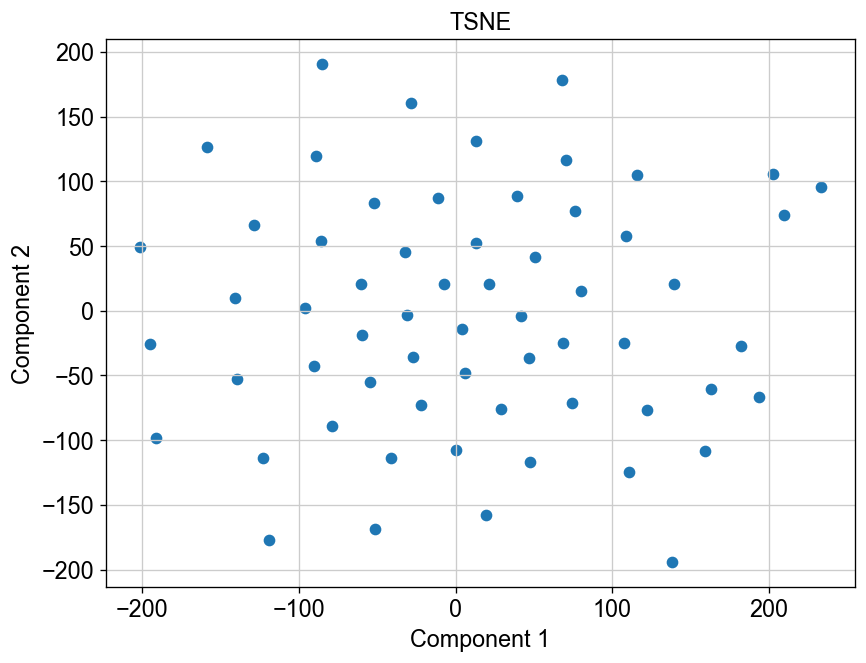

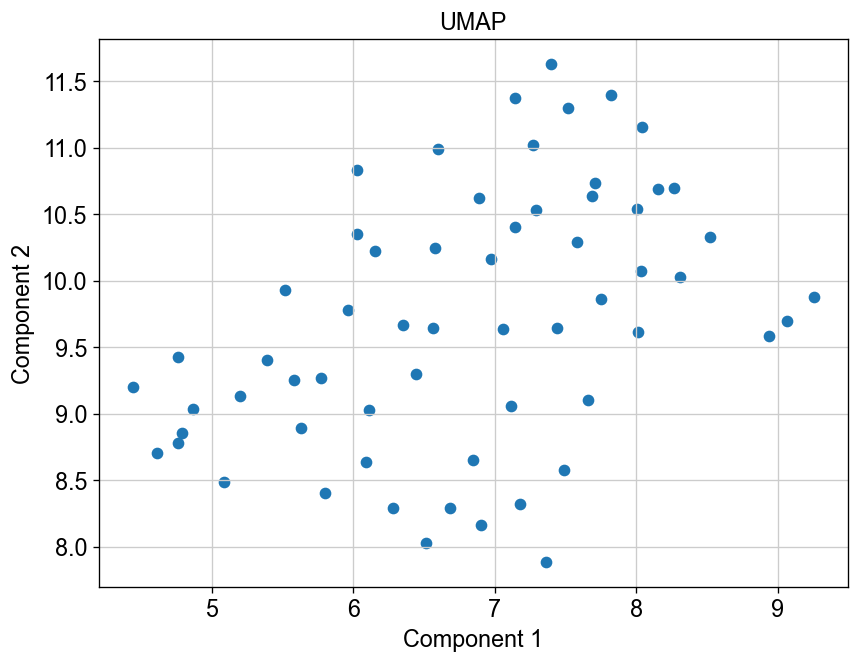

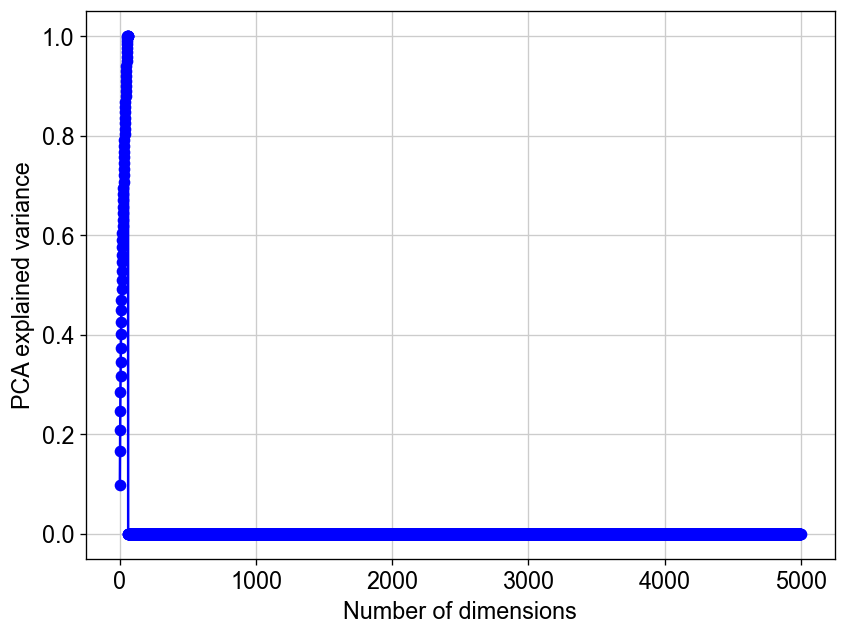

PCA needs 44 components to reach 90.0% of the total variance


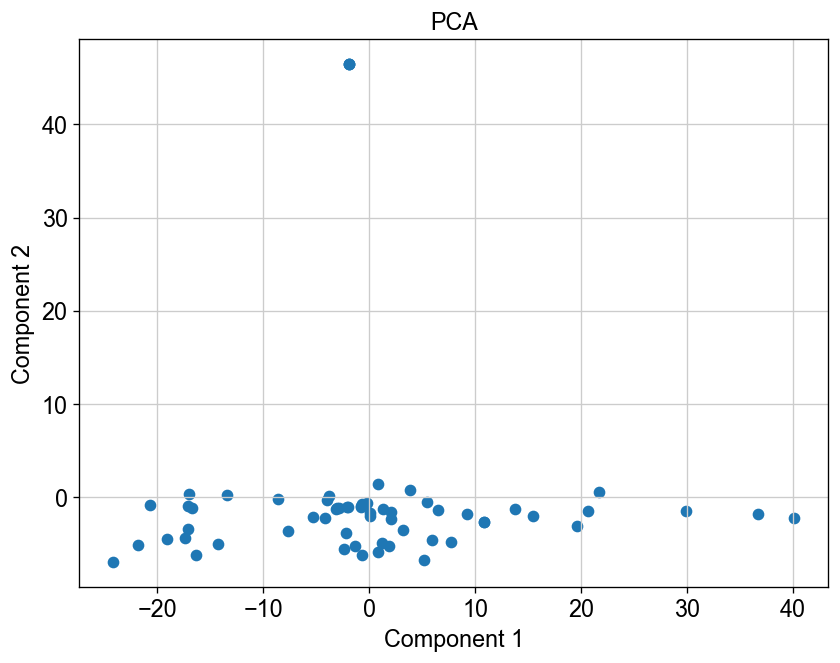

/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/katmast/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 60 nearest neighbors...
[t-SNE] Indexed 61 samples in 0.001s...
[t-SNE] Computed neighbors for 61 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 61 / 61
[t-SNE] Mean sigma: 24.083248
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.923508
[t-SNE] KL divergence after 1000 iterations: 0.563448


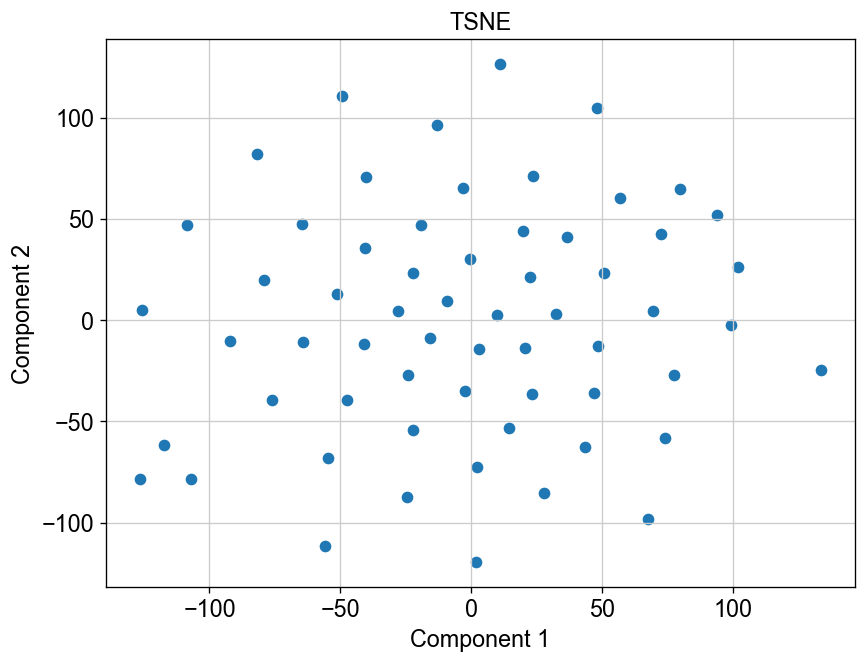

[7 1 3 4 6 4 5 3 7 6 2 1 4 4 2 1 8 5 1 4 1 6 8 6 4 1 5 2 6 1 7 1 1 1 1 2 6
 4 1 6 1 2 1 5 4 8 8 5 8 4 7 2 5 6 2 5 5 5 5 8 1]
Metrics:
   k       sil         bic        db         ch
0  2  0.272751  590.421488  1.377737  24.291382
1  3  0.238881  573.556147  1.321314  28.741484
2  4  0.166429  572.592115  1.556936  22.112581
3  5  0.161994  568.132105  1.282810  20.863443
4  6  0.129879  564.202662  1.438517  20.252058
5  7  0.005027  596.051254  2.645252   7.227346
6  8 -0.002269  585.038594  2.769702   9.921240


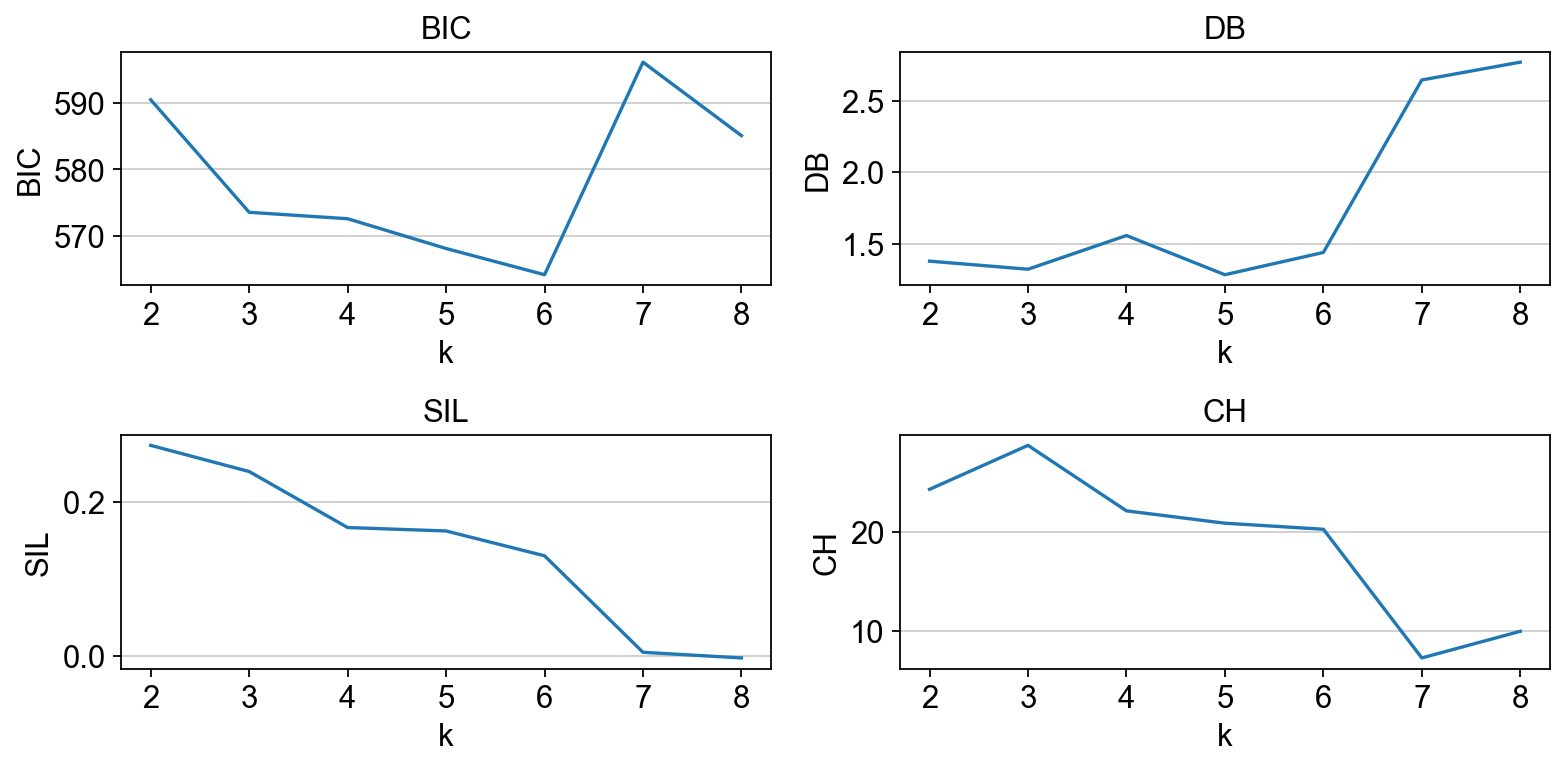

[5 0 2 0 0 3 5 5 5 0 5 3 0 0 3 3 5 2 1 3 0 4 3 2 5 5 3 0 0 0 5 2 3 4 4 2 5
 4 2 5 5 4 4 4 2 1 3 5 2 3 3 1 4 3 1 0 0 0 3 3 4]
ARI for  6  clusters:  0.00329609047649013
[-0.01473926322991875, -0.008101366975226277, -0.006972947130086508, -0.0009993162572976384, 0.00329609047649013, 0.0049364463428279975, 0.005350438288784895]


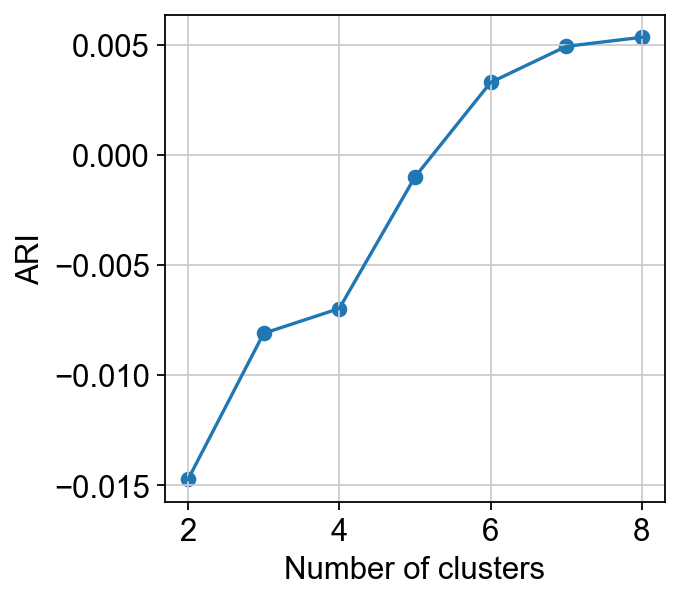

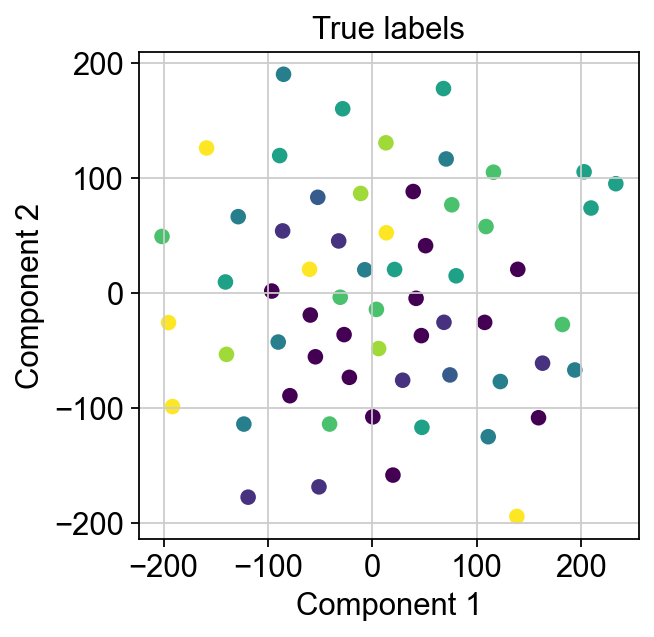

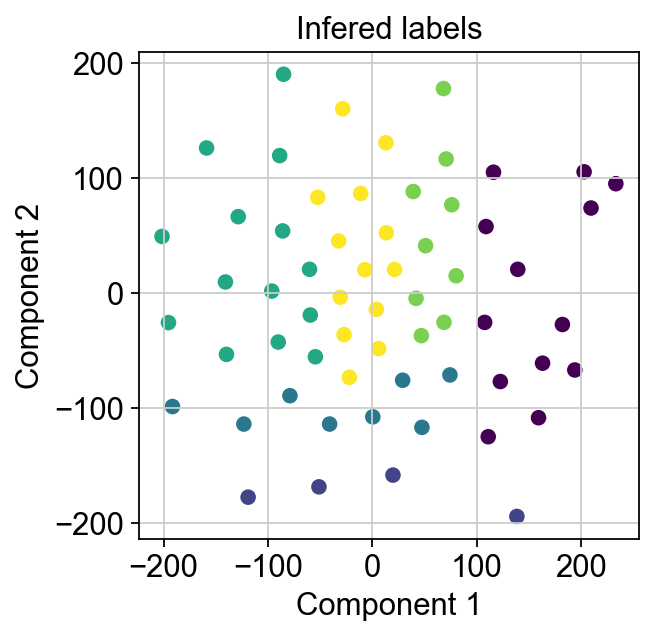

Metrics:
   k       sil        bic        db         ch
0  2  0.396790  18.218645  0.928925  54.639642
1  3  0.357448  -3.600957  1.075671  56.445646
2  4  0.380610 -15.510846  0.762578  53.795887
3  5  0.212059   4.214238  1.554290  27.525479
4  6  0.183500   5.623221  1.739974  23.104809
5  7  0.165715  -3.799302  1.821573  25.835121
6  8  0.048608  11.518578  2.512773  16.815866


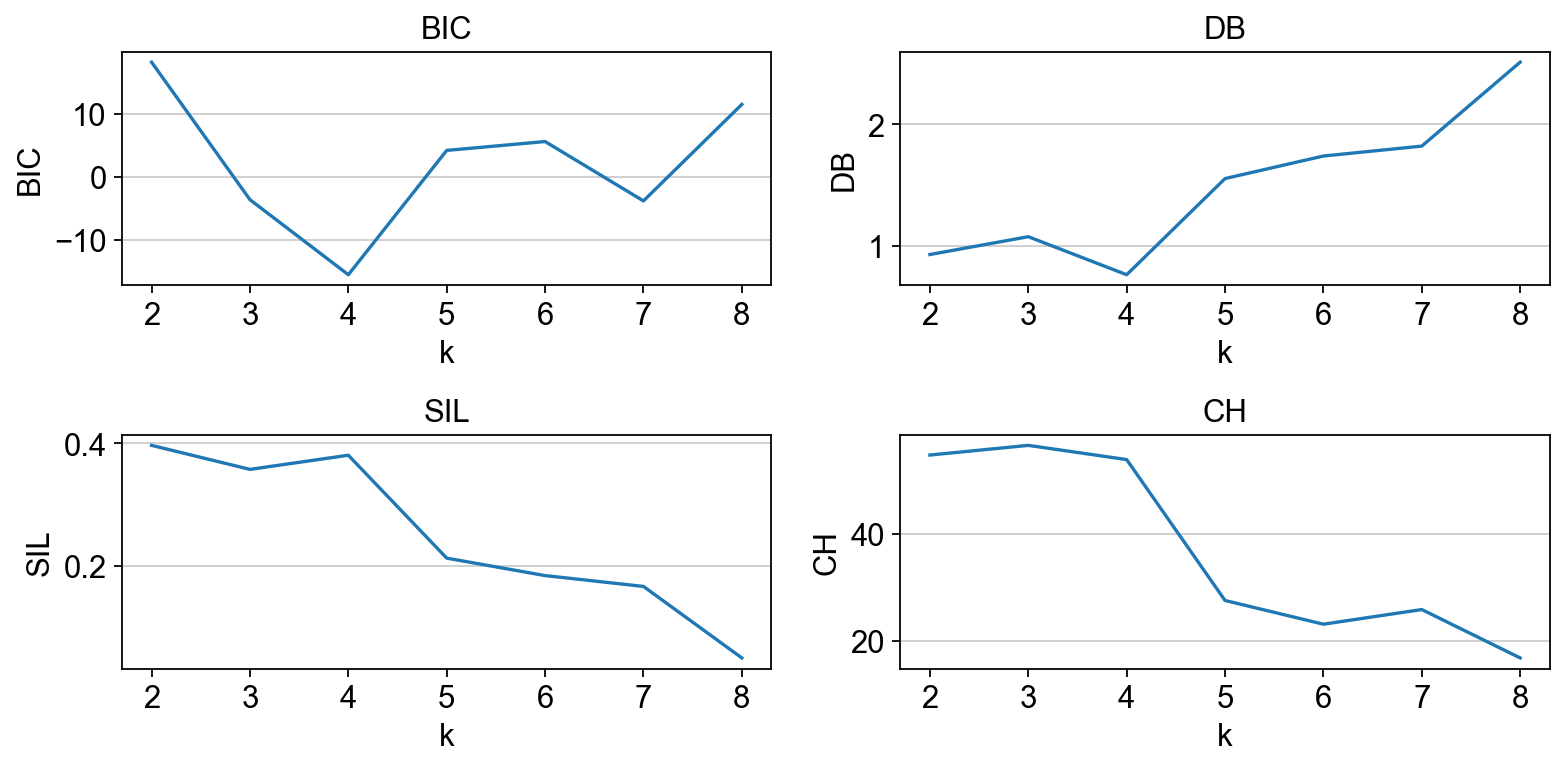

[2 1 1 1 0 1 0 3 2 0 4 5 1 1 1 5 0 2 1 5 0 0 2 1 3 4 0 1 1 2 5 3 5 4 0 2 2
 0 3 4 3 1 1 2 5 3 4 3 0 5 3 1 1 3 5 2 2 2 4 5 1]
ARI for  6  clusters:  0.028147652107969552
[-0.013318152268000876, -0.0070734033325505945, 0.008458182244516837, -0.003144634349951983, 0.028147652107969552, 0.03357643083638471, 0.025081865144595858]


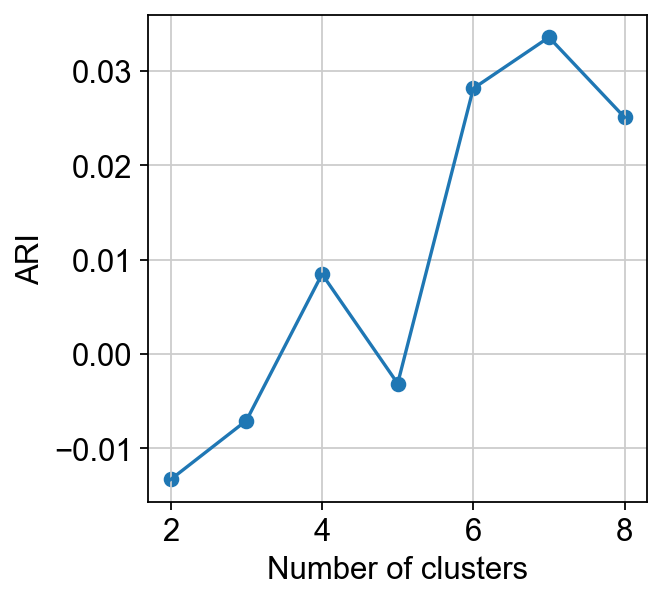

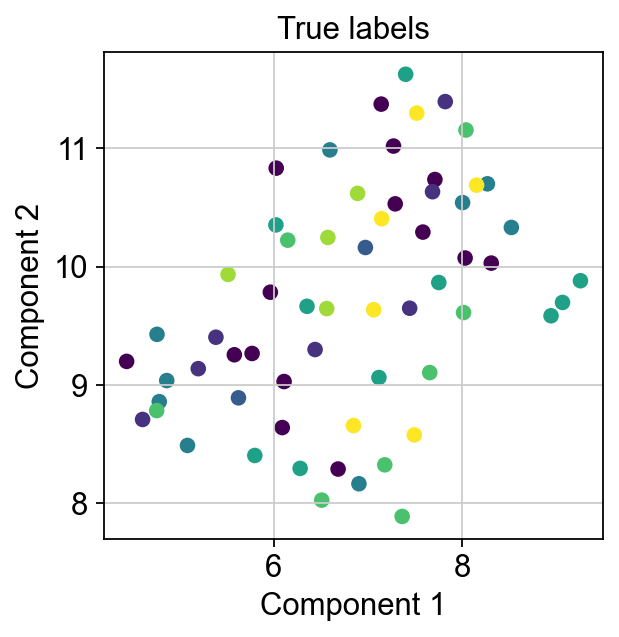

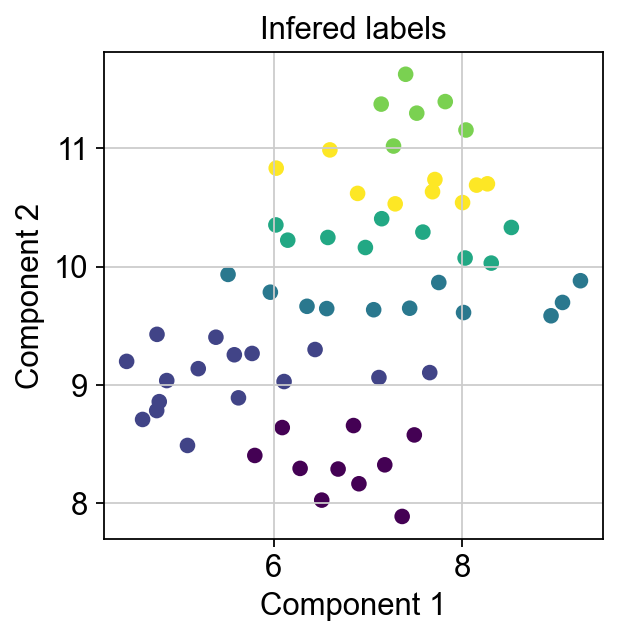

Metrics:
   k       sil         bic        db         ch
0  2  0.275618  525.387754  1.332781  26.232670
1  3  0.193482  520.210813  1.546838  19.784000
2  4  0.135363  520.514214  1.880025  15.020497
3  5  0.109106  515.974189  2.032260  14.887228
4  6  0.085661  515.945426  1.835110  13.290866
5  7 -0.011209  528.340173  2.594266   8.350624
6  8 -0.054127  534.367093  2.940802   6.573769


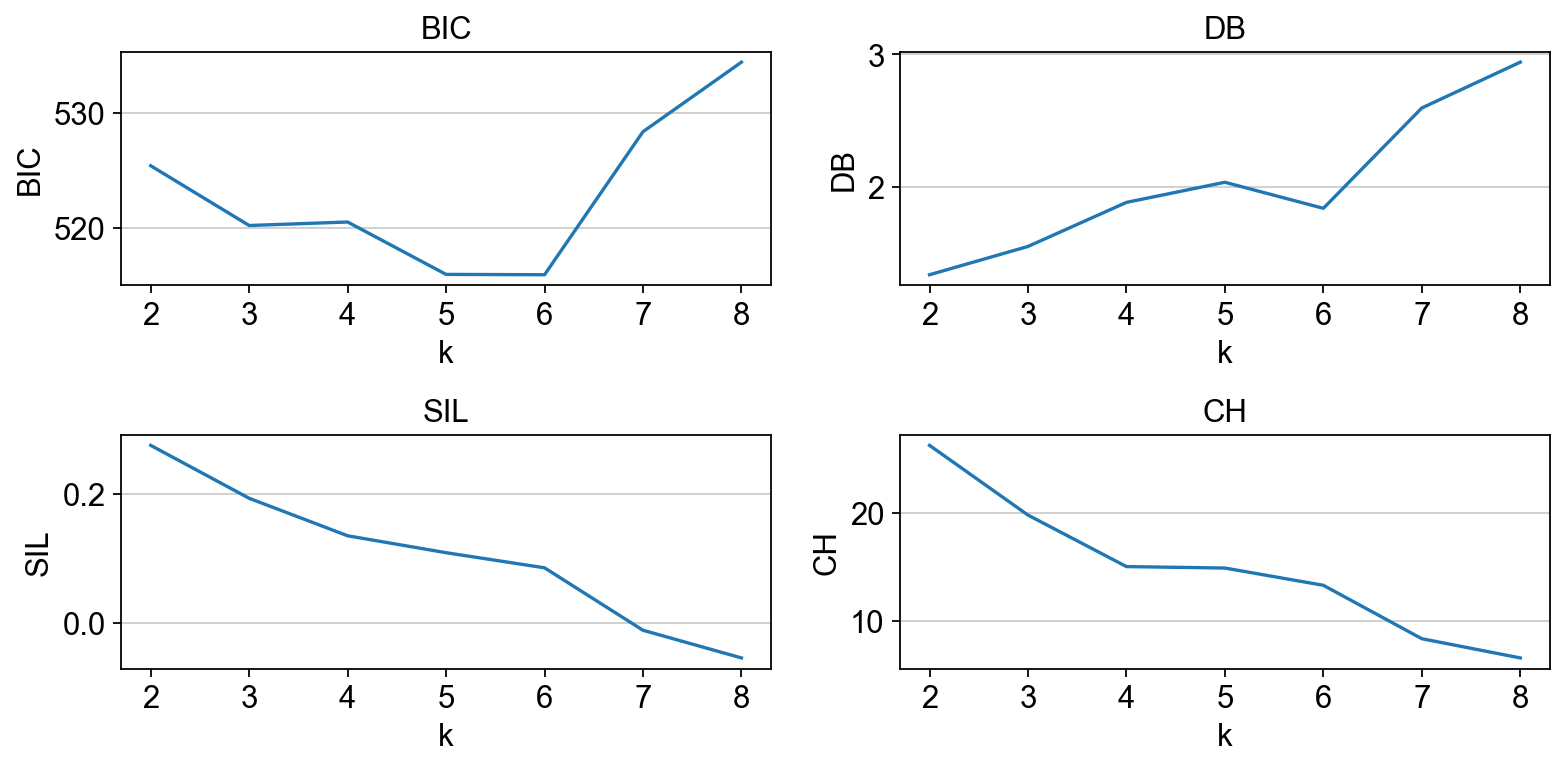

[4 3 0 3 0 0 2 4 1 0 1 2 4 4 3 4 3 2 1 1 3 1 3 2 2 2 3 4 4 1 3 0 3 2 0 3 3
 0 0 4 4 4 4 3 5 4 2 5 5 5 1 1 0 0 0 0 0 0 4 5 3]
ARI for  6  clusters:  0.0017644306721410874
[-0.003697486698581222, -0.0015260880226748734, -0.030907898498326803, 0.008281944715853347, 0.0017644306721410874, -0.02175378828205401, -0.01973177123477725]


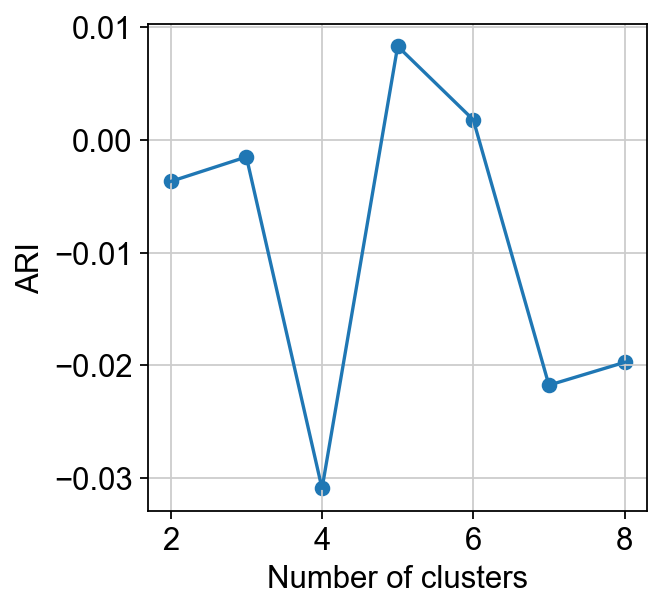

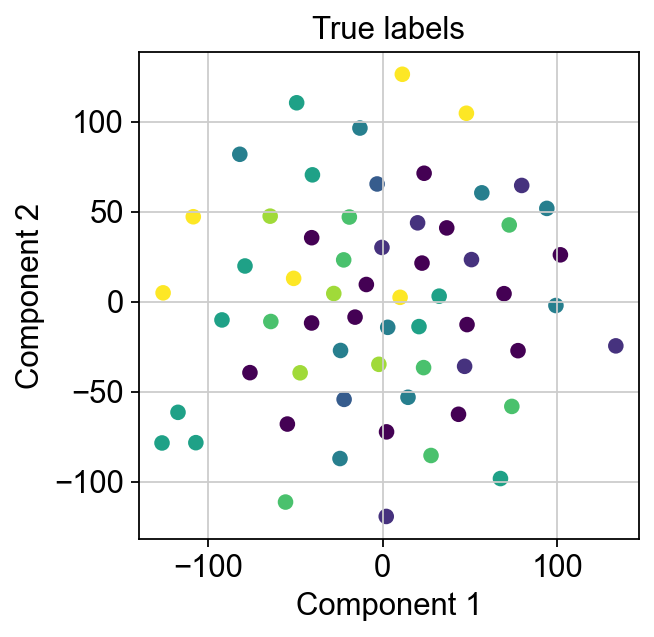

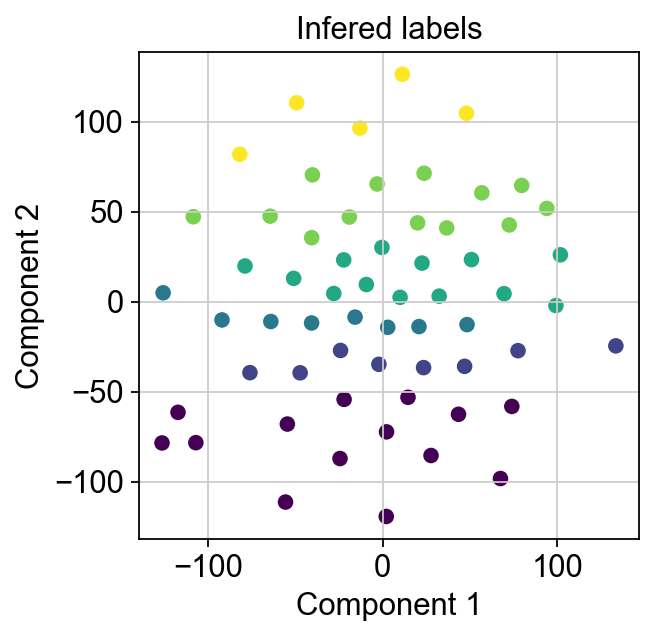

In [6]:
file = filtering_step()
file, data_tsne, data_umap, data_tsne_pca = dim_reduction_step(file)
consensus_step(file, data_tsne, data_umap, data_tsne_pca)

[7 1 3 4 6 4 5 3 7 6 2 1 4 4 2 1 8 5 1 4 1 6 8 6 4 1 5 2 6 1 7 1 1 1 1 2 6
 4 1 6 1 2 1 5 4 8 8 5 8 4 7 2 5 6 2 5 5 5 5 8 1]
[0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0
 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1]
[2 0 0 0 0 2 2 2 2 0 2 1 0 0 2 1 2 1 1 1 0 0 2 1 2 1 1 0 0 0 1 1 1 0 2 1 1
 2 1 1 1 0 0 0 1 0 1 2 1 2 1 1 2 2 1 0 0 0 2 2 0]
[2 0 0 0 1 2 1 2 1 1 2 3 0 0 2 2 1 0 3 3 1 1 2 3 2 3 2 0 0 0 3 3 3 1 1 0 3
 1 3 3 3 0 0 1 3 0 3 2 3 2 3 3 1 2 3 1 1 1 2 2 1]
[2 3 4 3 1 2 4 2 2 1 2 0 3 3 2 0 2 4 4 0 1 1 2 4 2 4 0 3 3 3 4 4 4 1 1 4 4
 1 0 4 4 4 4 1 0 3 0 2 0 2 0 0 1 0 4 1 1 1 2 2 4]
[4 3 3 3 1 4 0 4 4 1 0 0 3 3 4 5 0 2 2 5 1 1 0 2 0 2 5 3 3 3 0 2 0 0 1 2 0
 1 5 0 0 0 0 1 5 3 5 4 5 4 5 5 1 5 2 1 1 1 4 4 0]
[0 3 3 3 2 0 1 0 2 2 0 1 3 3 0 5 2 1 6 5 2 2 0 6 1 1 5 3 3 3 1 1 1 2 2 1 1
 2 6 1 1 1 1 2 6 3 5 0 5 0 5 6 2 5 6 4 4 4 0 0 1]
[4 2 2 2 6 5 1 4 4 6 1 1 2 2 5 5 6 7 7 0 6 6 1 7 1 7 5 2 2 2 1 7 1 6 6 7 1
 6 0 1 1 1 1 6 0 2 5 4 0 4 0 0 4 5 7 3 3 3 4 5 1]


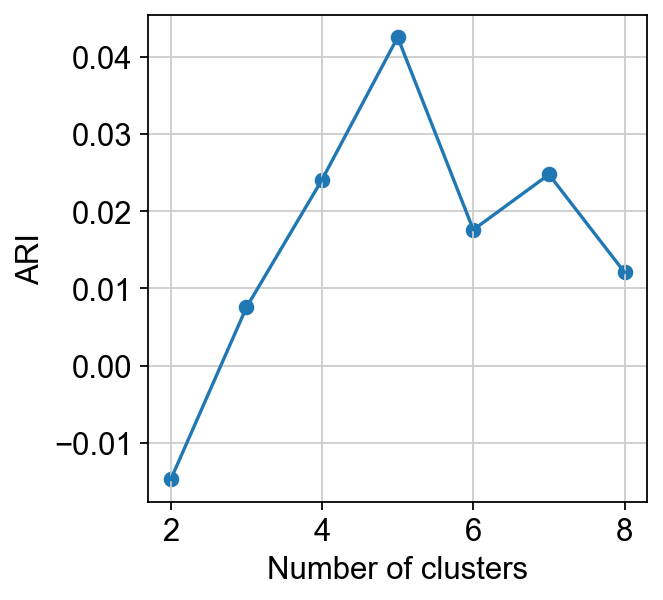

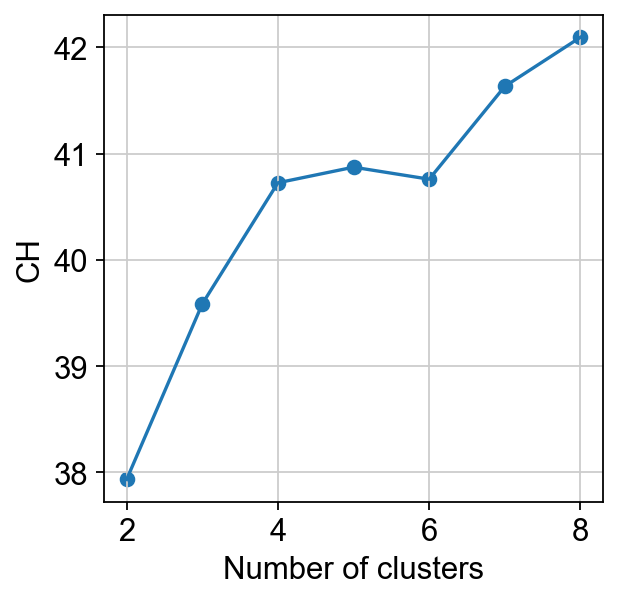

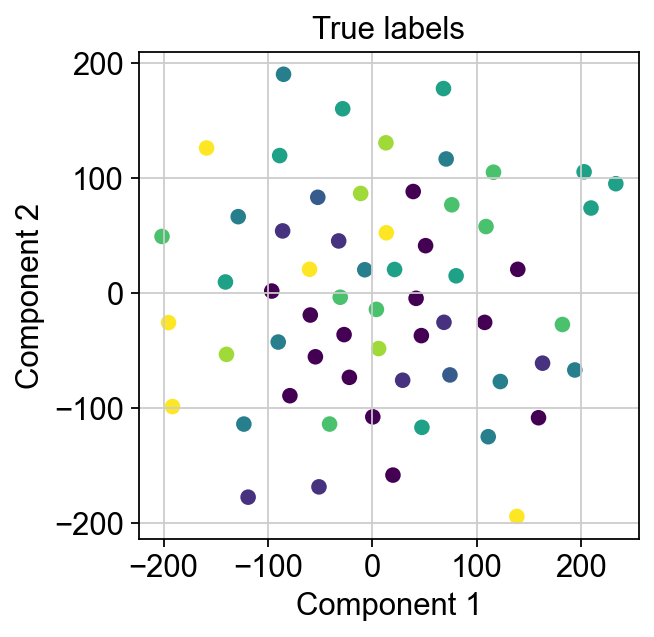

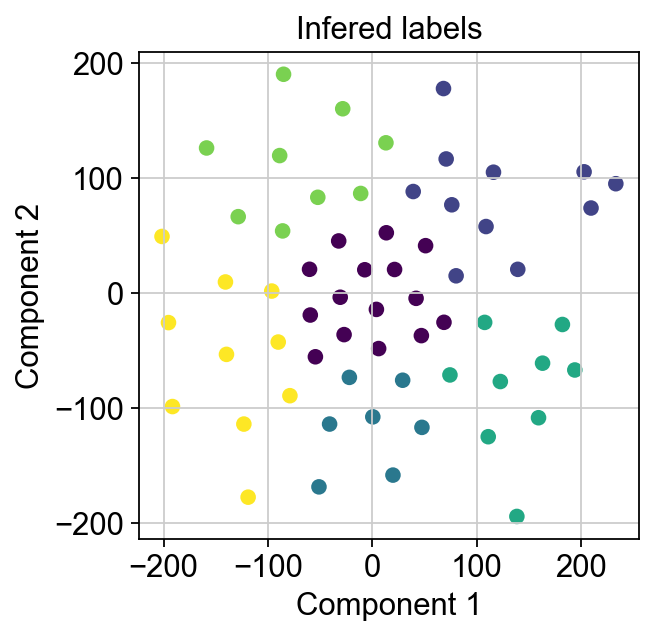

[1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1]
[0 0 0 0 1 0 0 2 1 1 2 2 0 0 0 0 1 2 0 2 1 1 1 1 2 2 1 0 0 0 2 2 2 2 1 2 2
 1 2 2 2 0 0 0 2 2 2 0 1 2 2 1 1 0 2 2 2 2 2 2 0]
[2 2 2 2 1 2 2 0 1 1 0 0 2 2 2 0 1 3 1 3 1 1 1 1 3 0 1 2 2 2 0 0 0 0 1 3 3
 1 3 0 3 2 2 1 3 0 0 0 1 0 0 1 1 0 0 3 3 3 0 3 2]
[0 4 4 4 3 4 4 0 0 3 1 1 4 4 4 0 3 2 0 1 3 3 0 2 2 1 3 4 4 0 1 1 1 1 3 2 2
 3 2 1 2 4 4 0 1 1 1 0 3 1 0 0 3 0 1 2 2 2 1 1 4]
[0 3 0 3 2 3 0 5 5 2 1 1 3 3 3 5 2 4 0 1 0 2 5 4 4 1 2 3 3 0 5 1 1 1 2 4 4
 2 4 1 4 0 0 0 1 5 1 5 2 5 5 0 2 5 1 4 4 4 1 1 0]
[2 6 2 6 0 6 0 5 5 0 1 1 6 6 6 5 0 4 2 1 0 0 4 4 3 1 0 6 6 2 5 1 1 1 0 4 4
 0 4 1 3 2 2 2 1 5 1 5 4 5 5 2 4 5 1 3 3 3 1 1 2]
[5 1 5 1 4 1 5 0 0 4 6 3 1 1 1 0 4 2 5 3 5 4 2 2 3 6 4 1 1 5 0 3 3 6 4 2 2
 4 3 6 3 5 5 0 3 0 6 0 4 0 0 5 2 0 3 7 7 7 6 3 5]
ARI:  0.025602849083848956


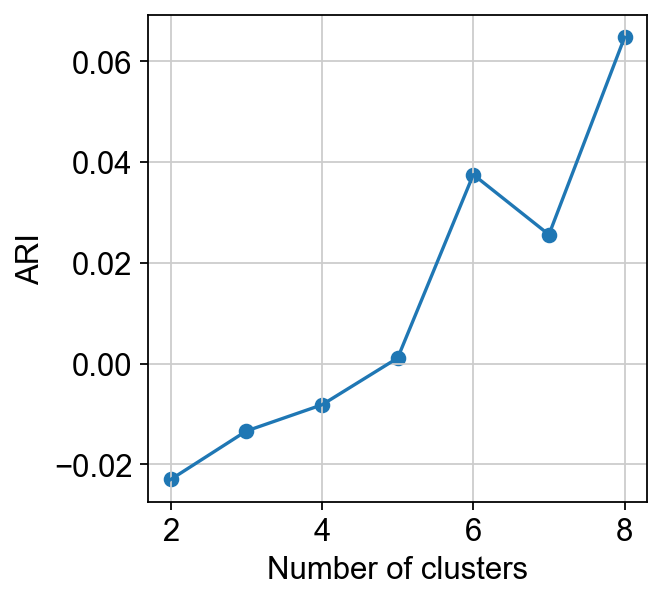

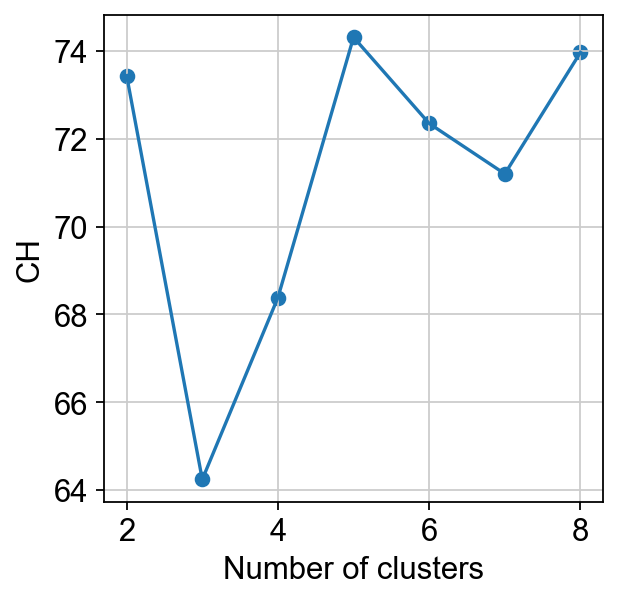

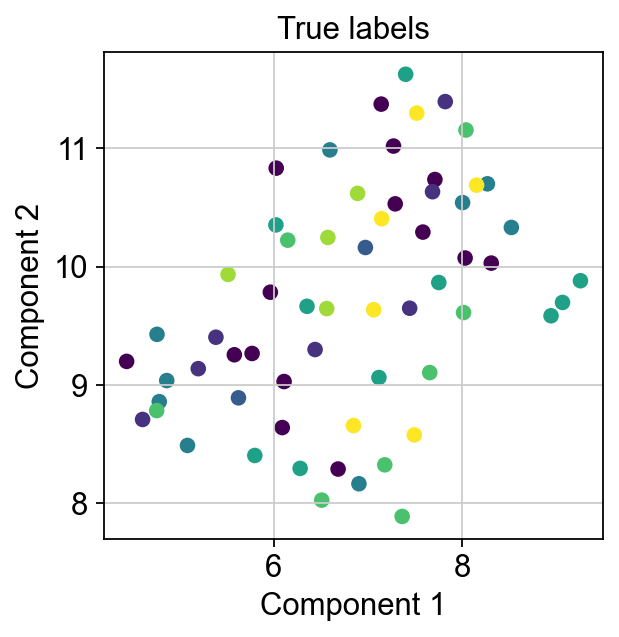

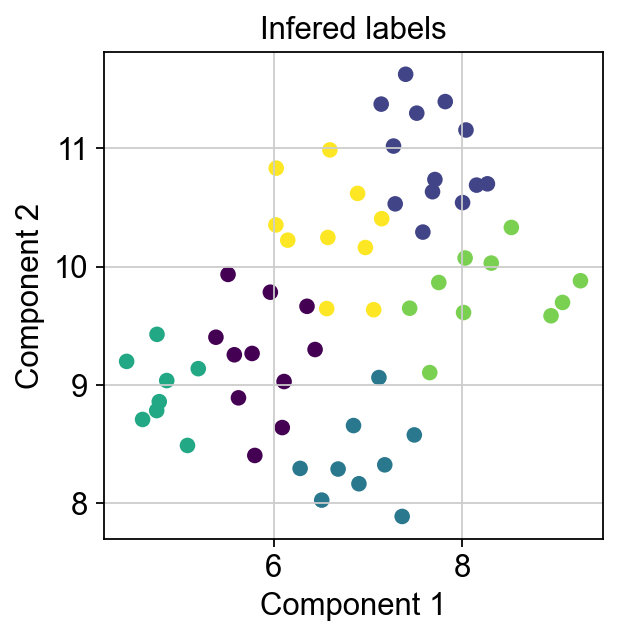

[0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1]
[0 2 1 2 2 1 2 0 1 2 2 1 2 2 2 0 2 1 2 1 2 2 1 1 2 1 1 2 2 1 1 2 0 2 1 0 0
 2 1 0 0 0 2 2 0 0 1 0 0 0 1 2 2 1 1 1 1 1 0 0 2]
[0 2 3 2 3 3 3 0 1 3 3 3 2 2 2 2 3 1 2 3 2 3 0 1 3 1 0 2 2 1 0 3 0 2 3 0 0
 3 1 0 0 2 2 2 0 0 1 0 0 0 3 2 3 1 3 1 1 1 0 2 2]
[3 2 4 2 4 1 4 0 1 4 4 3 2 2 2 0 2 3 2 3 2 4 3 3 4 3 3 2 2 1 3 4 3 2 4 3 3
 4 1 0 3 2 2 2 0 3 3 0 0 0 4 2 4 1 4 1 1 1 0 0 2]
[4 2 5 2 5 5 3 0 1 5 5 3 2 2 2 0 3 1 2 3 2 5 4 1 3 3 4 2 2 1 3 5 3 2 5 3 3
 5 1 0 4 0 2 3 0 4 4 0 0 4 3 2 5 1 5 1 1 1 0 0 3]
[6 5 4 5 0 4 3 1 4 0 0 3 5 1 5 1 3 2 0 3 5 0 3 2 3 3 6 5 5 2 3 0 3 0 4 3 3
 0 4 3 6 1 1 3 1 6 2 6 1 6 3 5 0 4 4 2 2 2 6 1 3]
[6 5 3 2 3 3 7 0 4 2 2 4 5 5 7 0 7 6 2 4 2 3 4 4 4 4 6 5 5 1 4 3 4 2 3 7 4
 3 1 0 4 7 7 7 0 6 6 0 0 6 3 2 3 1 3 1 1 1 0 5 7]
ARI:  -0.006818713306337465


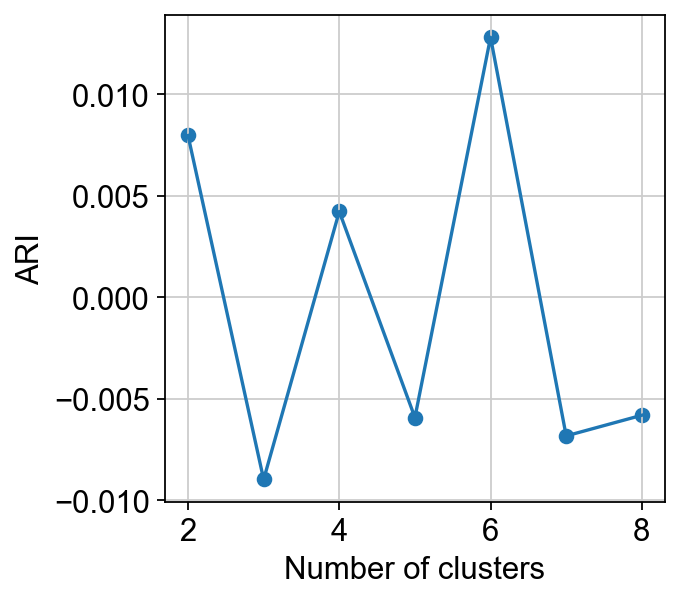

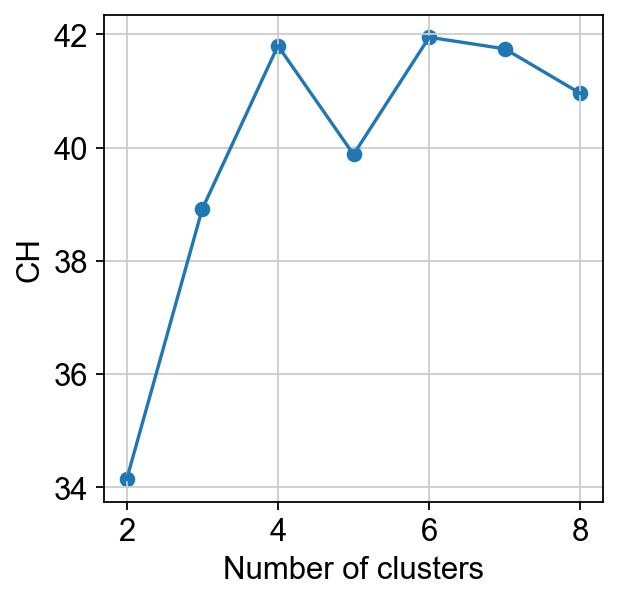

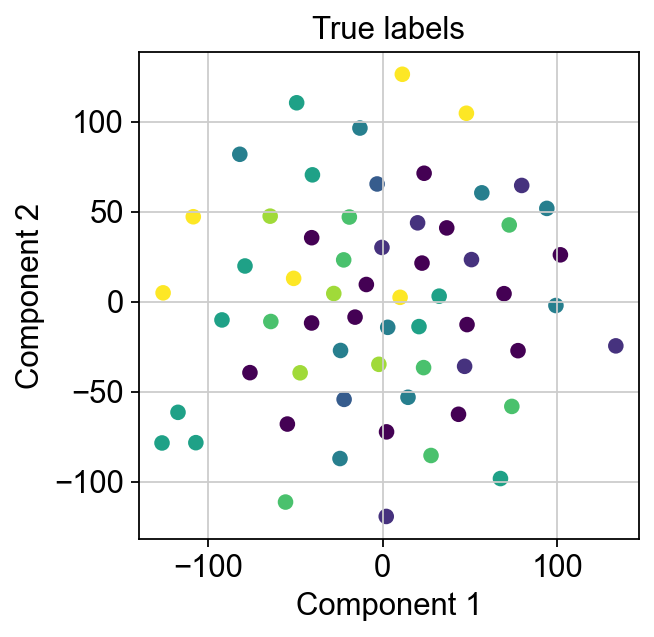

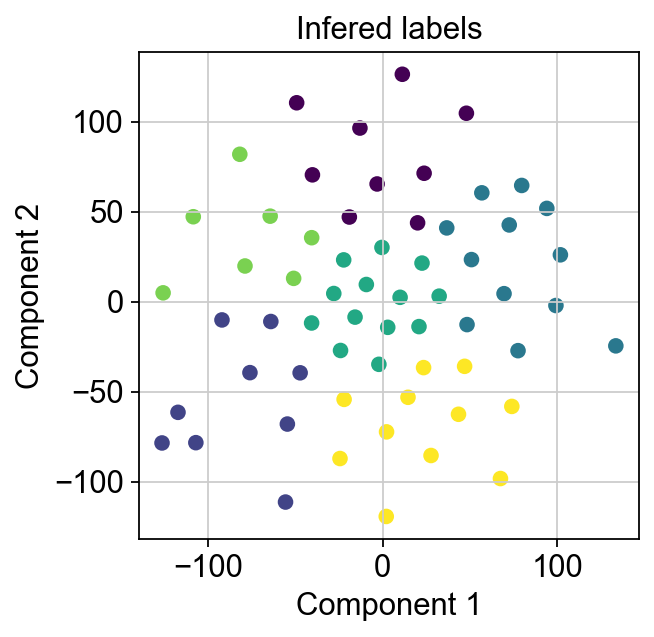

In [18]:
true_labels = true_data_labels("temp4.txt")
kmeans(data_tsne,true_labels)
kmeans(data_umap,true_labels)
kmeans(data_tsne_pca,true_labels)

/var/folders/_v/s5lbvxf12slcbq1gy6s65kpr0000gn/T/ipykernel_32606/2159123948.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  plot_heatmap_original("dataSp.txt")


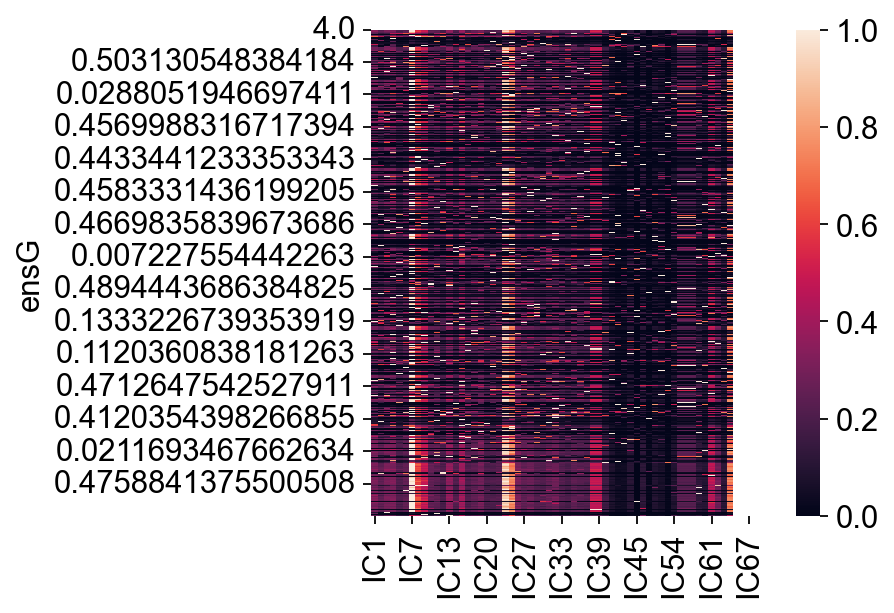

In [11]:
plot_heatmap_original("dataSp.txt")

/var/folders/_v/s5lbvxf12slcbq1gy6s65kpr0000gn/T/ipykernel_32606/1335371295.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  plot_heatmap_transformed("temp4.txt")


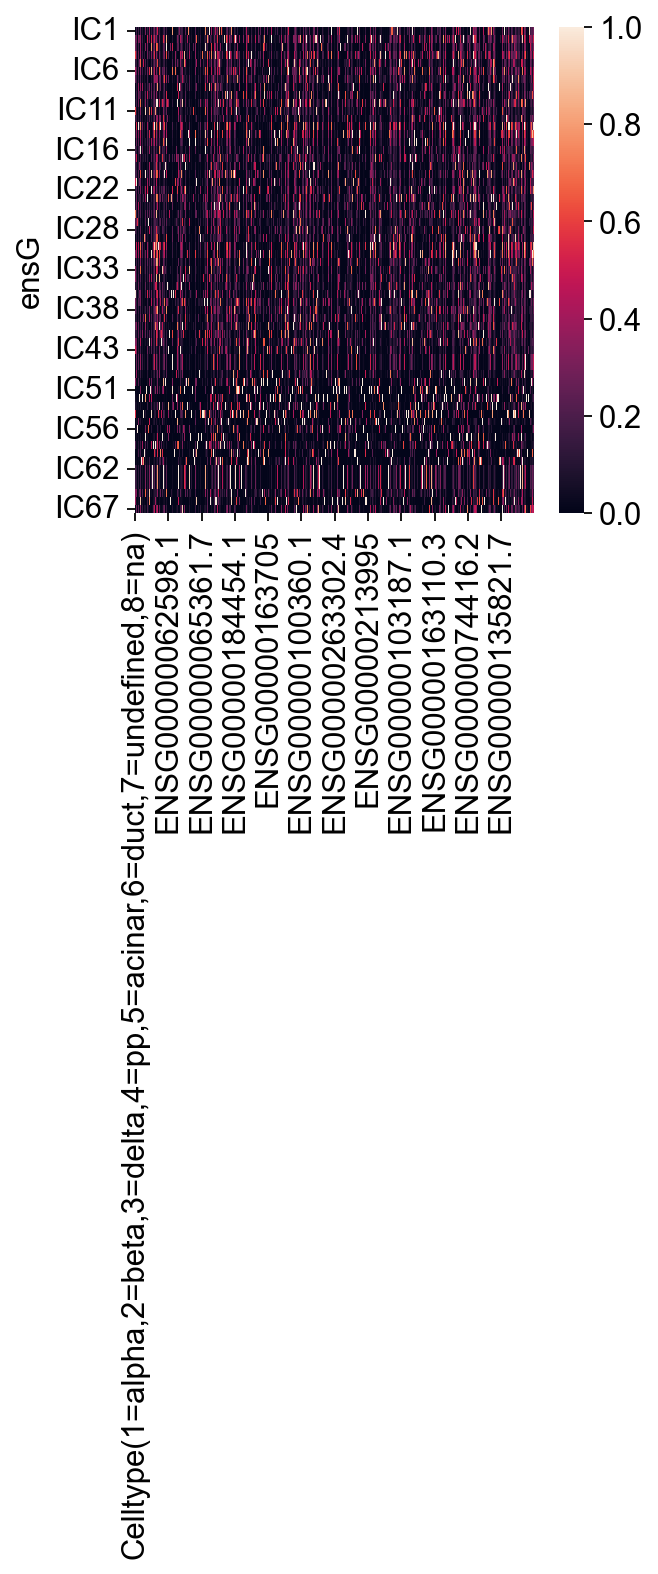

In [14]:
plot_heatmap_transformed("temp4.txt")